Using TensorFlow backend.


(50000, 28, 28) (50000,)


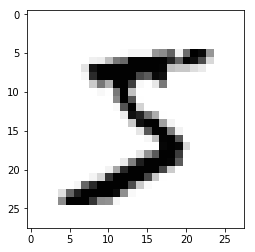

In [1]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [2]:
print ("X.shape: ", X_train.shape, ", y.shape: ", y_train.shape)
print ("val.shape: ", X_val.shape )
print ("test.shape: ", X_test.shape )

X.shape:  (50000, 28, 28) , y.shape:  (50000,)
val.shape:  (10000, 28, 28)
test.shape:  (10000, 28, 28)


In [3]:
learning_rate = .001
log_dir = "./log"
dropout = 0.9
max_steps = 1000
total_train_imgs = X_train.shape[0]

In [4]:
import tensorflow as tf

sess = tf.InteractiveSession()

In [5]:
# Input placeholders
with tf.name_scope('input'):
    x_tf = tf.placeholder(tf.float32, [None, 28, 28], name='x-input')
    y_tf = tf.placeholder(tf.int64, [None], name='y-input')
    x_reshaped = tf.reshape(x_tf, [-1, 784])
    image_shaped_input = tf.reshape(x_reshaped, [-1, 28, 28, 1])
    tf.summary.image('input', image_shaped_input, 10)

In [6]:
# Initialize the weight to small variable
def weight_variable(shape):
    """Create a weight variable with appropriate initialization."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

In [7]:
# Create a bias variable 
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [8]:
def variable_summaries(var):
    """Attach summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [9]:
def nn_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.relu):
    """a simple neural net layer.
    It does a matrix multiply, bias add, and then uses ReLU to nonlinearize.
    It also sets up name scoping so that the resultant graph is easy to read,
    and adds a number of summary ops.
    """
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
        # This Variable will hold the state of the weights for the layer
        with tf.name_scope('weights'):
            weights = weight_variable([input_dim, output_dim])
            variable_summaries(weights)
        with tf.name_scope('biases'):
            biases = bias_variable([output_dim])
            variable_summaries(biases)
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights) + biases
            tf.summary.histogram('pre_activations', preactivate)
        activations = act(preactivate, name='activation')
        tf.summary.histogram('activations', activations)
        return activations

In [10]:
hidden1 = nn_layer(x_reshaped, 784, 500, 'layer1')

In [11]:
with tf.name_scope('dropout'):
    keep_prob = tf.placeholder(tf.float32)
    tf.summary.scalar('dropout_keep_probability', keep_prob)
    dropped = tf.nn.dropout(hidden1, keep_prob)

In [12]:
y = nn_layer(dropped, 500, 10, 'layer2', act=tf.identity)

In [13]:
with tf.name_scope('cross_entropy'):
    # The raw formulation of cross-entropy,
    #
    # tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.softmax(y)),
    #                               reduction_indices=[1]))
    #
    # can be numerically unstable.
    #
    # So here we use tf.losses.sparse_softmax_cross_entropy on the
    # raw logit outputs of the nn_layer above, and then average across
    # the batch.
    with tf.name_scope('total'):
        cross_entropy = tf.losses.sparse_softmax_cross_entropy(
        labels=y_tf, logits=y)

In [14]:
tf.summary.scalar('cross_entropy', cross_entropy)

<tf.Tensor 'cross_entropy_1:0' shape=() dtype=string>

In [15]:
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(
        cross_entropy)

In [16]:
with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(tf.argmax(y, 1), y_tf)
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [17]:
tf.summary.scalar('accuracy', accuracy)

<tf.Tensor 'accuracy_1:0' shape=() dtype=string>

In [18]:
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
test_writer = tf.summary.FileWriter(log_dir + '/test')
tf.global_variables_initializer().run()

In [19]:
# Train the model, and also write summaries.
# Every 10th step, measure test-set accuracy, and write test summaries
# All other steps, run train_step on training data, & add training summaries

def feed_dict(train, step):
    """Make a TensorFlow feed_dict: maps data onto Tensor placeholders."""
    if train=="train":
        beg = step*100
        beg = beg % total_train_imgs
        xs, ys = X_train[beg:beg+100,], y_train[beg:beg+100,]
        k = dropout
    elif train=='val':
        xs, ys =  X_val, y_val
        k = 1.0
    else:
        xs, ys = X_test, y_test
        k = 1.0
    return {x_tf: xs, y_tf: ys, keep_prob: k}

In [20]:
train_acc = 0.0
steps = []
train_plt = []
test_plt = []
for i in range(max_steps):
    if i % 10 == 0:  # Record summaries and test-set accuracy
        summary, acc = sess.run([merged, accuracy], feed_dict=feed_dict("test", i))
        test_writer.add_summary(summary, i)
#        print('Accuracy at step %s: train=%s, test=%s' % (i, train_acc, acc))
        steps.append(i)
        train_plt.append(train_acc)
        test_plt.append(acc)
    else:  # Record train set summaries, and train
        if i % 100 == 99:  # Record execution stats
            run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
            run_metadata = tf.RunMetadata()
            summary, train_acc, _ = sess.run([merged, accuracy, train_step],
                          feed_dict=feed_dict("train", i),
                          options=run_options,
                          run_metadata=run_metadata)
            train_writer.add_run_metadata(run_metadata, 'step%03d' % i)
            train_writer.add_summary(summary, i)
#            print('Adding run metadata for', i)
        else:  # Record a summary
            summary, train_acc, _ = sess.run([merged, accuracy, train_step], feed_dict=feed_dict("train", i))
            train_writer.add_summary(summary, i)

Accuracy at step 0: train=0.0, test=0.0998
Accuracy at step 10: train=0.72, test=0.6953
Accuracy at step 20: train=0.77, test=0.817
Accuracy at step 30: train=0.8, test=0.848
Accuracy at step 40: train=0.88, test=0.8681
Accuracy at step 50: train=0.88, test=0.8851
Accuracy at step 60: train=0.9, test=0.8913
Accuracy at step 70: train=0.82, test=0.8853
Accuracy at step 80: train=0.88, test=0.8906
Accuracy at step 90: train=0.87, test=0.904
Adding run metadata for 99
Accuracy at step 100: train=0.94, test=0.9103
Accuracy at step 110: train=0.95, test=0.912
Accuracy at step 120: train=0.91, test=0.9062
Accuracy at step 130: train=0.88, test=0.8984
Accuracy at step 140: train=0.88, test=0.9151
Accuracy at step 150: train=0.89, test=0.9153
Accuracy at step 160: train=0.89, test=0.9243
Accuracy at step 170: train=0.9, test=0.9264
Accuracy at step 180: train=0.91, test=0.9257
Accuracy at step 190: train=0.96, test=0.9274
Adding run metadata for 199
Accuracy at step 200: train=0.9, test=0.9263

In [21]:
train_writer.close()
test_writer.close()

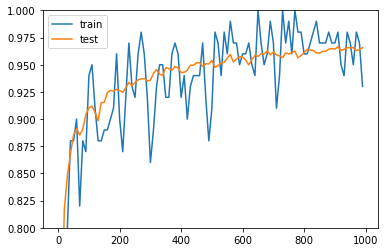

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(steps, train_plt,  label="train")
plt.plot(steps, test_plt,   label="test")
plt.ylim(0.8, 1.0) 
plt.legend();